# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных:**
1. id — уникальный идентификатор скважины;
2. f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
3. product — объём запасов в скважине (тыс. баррелей).


**Условия:**

1. Для обучения модели подходит только линейная регрессия;
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
3. Бюджет на разработку скважин в регионе — 10 млрд рублей;
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
   
    

## Загрузка и подготовка данных

Импортируем необходимые библиотеки, модели, метрики и другое, что пригодится в исследовании:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')
state = np.random.RandomState(12345)

Изучим данные на наличие дубликатов, пропусков, правильность отображения:

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Рассмотрим каждый из регионов по отдельности.

**Первый регион:**

In [3]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
data_0[data_0['product'] == 0]['product'].count()

1

In [7]:
data_0.duplicated().sum()

0

**Второй регион:**

In [8]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [11]:
data_1[data_1['product'] == 0]['product'].count()

8235

In [12]:
data_1.duplicated().sum()

0

**Третий регион:**

In [13]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [14]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [15]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [16]:
data_2[data_2['product'] == 0]['product'].count()

1

In [17]:
data_2.duplicated().sum()

0

В приведенных данных нет пропусков и дубликатов, указаны необходимые типы данных.
Необходимо убрать столбец id из-за неинформативности:

In [18]:
data_0.drop('id', axis=1, inplace=True)
data_1.drop('id', axis=1, inplace=True)
data_2.drop('id', axis=1, inplace=True)

Также посмотрим также на корреляцию данных:

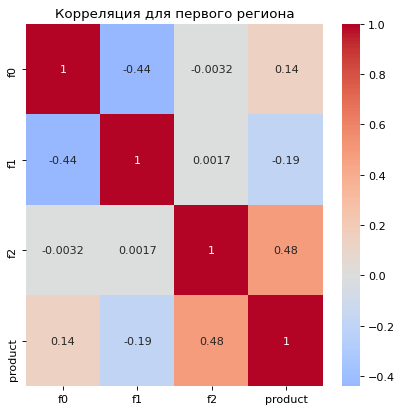

In [19]:
plt.figure(figsize=(6,6), dpi= 80)
sns.heatmap(data_0.corr(),  cmap='coolwarm', center=0, annot=True)
plt.title('Корреляция для первого региона')
plt.show()

В первом регионе прослеживается средняя отрицательная корреляция между f0 и f1, а также между f1 и целевым признаком (product). Слабо положительно коррелирует f2 с целевым признаком.

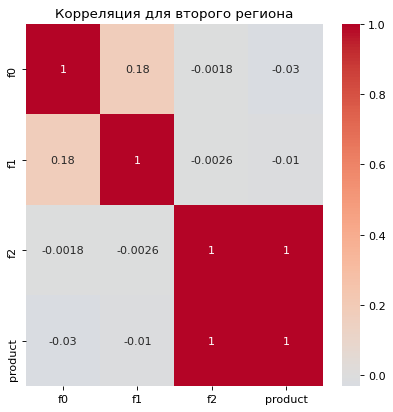

In [20]:
plt.figure(figsize=(6,6), dpi= 80)
sns.heatmap(data_1.corr(),  cmap='coolwarm', center=0, annot=True)
plt.title('Корреляция для второго региона')
plt.show()

Во втором регионе полностью взаимосвязаны f2 и целевой признак.

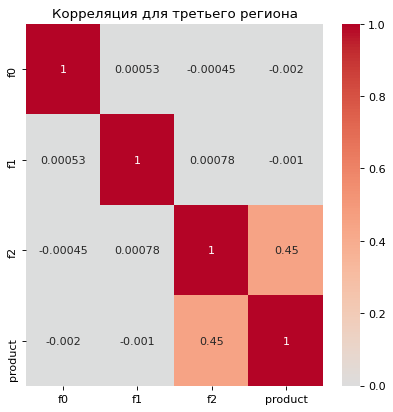

In [21]:
plt.figure(figsize=(6,6), dpi= 80)
sns.heatmap(data_2.corr(),  cmap='coolwarm', center=0, annot=True)
plt.title('Корреляция для третьего региона')
plt.show()

В третьем регионе прослеживается средняя положительная корреляция между между f2 и целевым признаком.

Посмотрим на гистограммы:

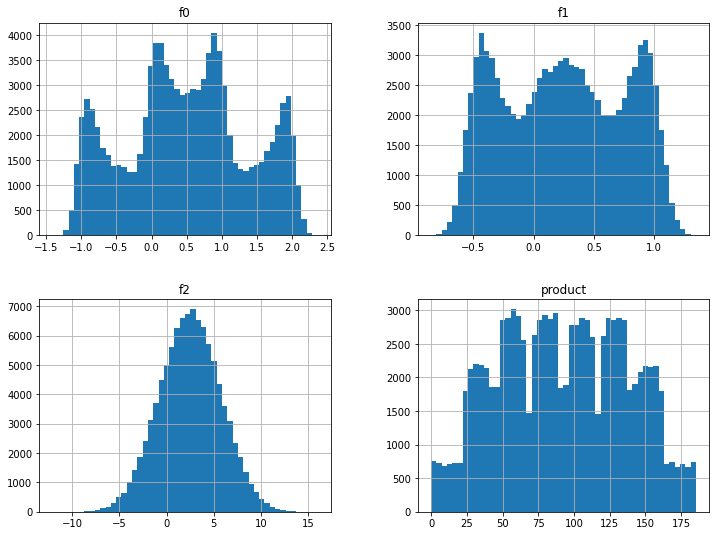

In [22]:
data_0.hist(bins = 50, figsize=[12,9])
plt.show()

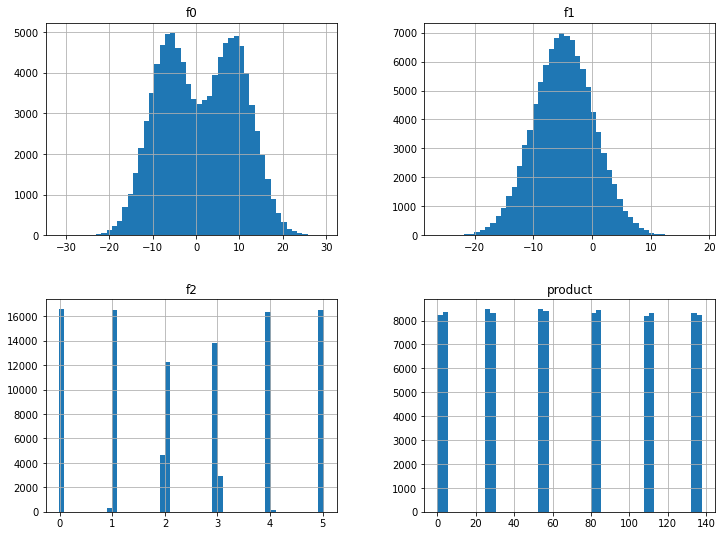

In [23]:
data_1.hist(bins = 50, figsize=[12,9])
plt.show()

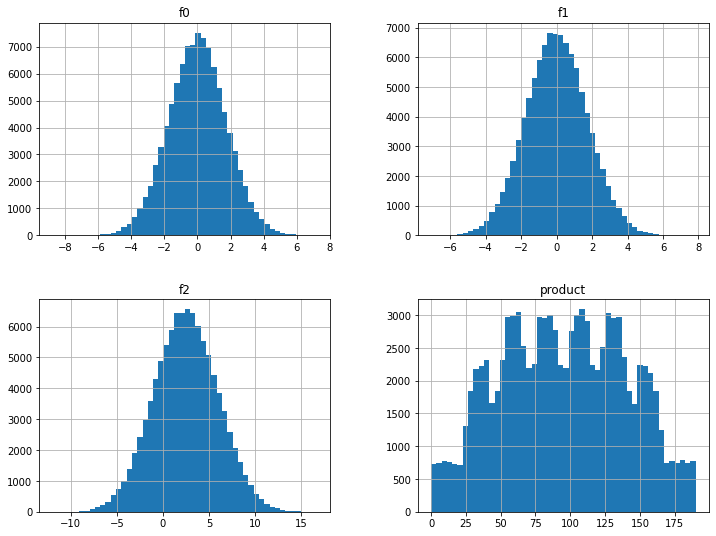

In [24]:
data_2.hist(bins = 50, figsize=[12,9])
plt.show()

**Вывод:**
1. Были рассмотрены данные, выявлено, что отсутствуют пропуски и дубликаты, тип данных в столбцах указан корректно;
2. В таблицах удален столбец id из-за неинформативности;
3. В таблицах присутствуют нулевые значения в product, которые либо были утрачены, либо не было изучены данные месторождения на наличие нефти;
4. Целевой признак - product;
5. Прослеживается положительная корреляция между f2 и product. Для второго региона она равна 1, что может в дальшнейшем сказатьсч на предсказании;
6. У первого и третьего региона, согласно гистограммам, распределение скважин близкое к нормальному, в отличие от второго региона. 

Можно приступать к следующему этапу.

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Что мне понравилось:<br>

Ты не просто считал данные и разбил на выборки, а сделал базовый их анализ, построил гистограммы и тепловые карты, проверил на повторения id. Супер 👍
<br />

## Обучение и проверка модели

Разобьем наши данные на на обучающую и валидационную выборки в соотношении 75:25 :

In [25]:
target_0 = data_0['product']
features_0 = data_0.drop('product', axis=1)

target_1 = data_1['product']
features_1 = data_1.drop('product', axis=1)

target_2 = data_2['product']
features_2 = data_2.drop('product', axis=1)

In [26]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

Обучим модели "Логическая регрессия" для каждого региона, сделаем предсказания и оценим качество по RMSE.

Начем с **Первого региона:**

In [27]:
model_0=LinearRegression()
model_0.fit(features_train_0,target_train_0)
predict_0=model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predict_0)**0.5
print('RMSE модели:', rmse_0)
print('Средний запас предсказанного сырья:', predict_0.mean())

RMSE модели: 37.5794217150813
Средний запас предсказанного сырья: 92.59256778438035


**Второй регион:**

In [28]:
model_1=LinearRegression()
model_1.fit(features_train_1,target_train_1)
predict_1=model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predict_1)**0.5
print('RMSE модели:', rmse_1)
print('Средний запас предсказанного сырья:', predict_1.mean())

RMSE модели: 0.893099286775617
Средний запас предсказанного сырья: 68.728546895446


**Третий регион:**

In [29]:
model_2=LinearRegression()
model_2.fit(features_train_2,target_train_2)
predict_2=model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
print('RMSE модели:', rmse_2)
print('Средний запас предсказанного сырья:', predict_2.mean())

RMSE модели: 40.02970873393434
Средний запас предсказанного сырья: 94.96504596800489


**Вывод:**
1. Наилучший результат RMSE оказался у второго региона, что также можно связать с сильной корреляцией между целевым признаком и признаками точек;
2. В первом и втором примерно одинаковый средний запас сырья, который больше, чем у второго региона, однако они уступают второму по RMSE.

Переходим к следующему этапу.

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Что мне понравилось:<br>

Все требования заказчика соблюдены, данные корректно разбиты, модели корректно обучены 👍
<br />

## Подготовка к расчёту прибыли

Укажем ключевые переменные из условий:

In [30]:
budget = 10**10 #Бюджет на разработку скважин в регионе
income = 450000 #доход 
income_one = 450
risk = 0.025 # допустимый риск
chosen_point = 500
best_point = 200 #количество вышек для обучения
budget_per_point = budget/best_point
min_volume = budget/best_point/income #Достаточный объем добычи для безубыточной разработки, тыс.барр

#средний запас сырья для каждого региона:
product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()

In [31]:
print('Достаточный объём сырья для безубыточной разработки новой скважины (тыс. баррелей):', min_volume)
print('Средний истинный запас скважины первого региона (тыс. баррелей):', product_mean_0)
print('Средний истинный запас скважины второго региона (тыс. баррелей):', product_mean_1)
print('Средний истинный запас скважины третьего региона (тыс. баррелей):', product_mean_2)

Достаточный объём сырья для безубыточной разработки новой скважины (тыс. баррелей): 111.11111111111111
Средний истинный запас скважины первого региона (тыс. баррелей): 92.50000000000001
Средний истинный запас скважины второго региона (тыс. баррелей): 68.82500000000002
Средний истинный запас скважины третьего региона (тыс. баррелей): 95.00000000000004


**Вывод:**
1. Чтобы получать прибыль, нужно будет выбрать скважины с запасами выше 111.11 тыс.баррелей;
2. В каждом из регионов средний запас меньше, чем достаточный объём сырья для безубыточной разработки новой скважины.

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Расчёт необходимого количества нефти корректен
<br />

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Вывод стоит дополнить фразой в духе "именно поэтому мы сейчас применим машинное обучение" 🙂
    </font>

</div>

## Расчёт прибыли и рисков 

Напишем **функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**

Сохраним верные ответы, сбросим индексы:

In [33]:
target_0 = target_valid_0.reset_index(drop=True)
target_1 = target_valid_1.reset_index(drop=True)
target_2 = target_valid_2.reset_index(drop=True)

Переведем предсказания в Series:

In [34]:
predict_0 = pd.Series(predict_0)
predict_1 = pd.Series(predict_1)
predict_2 = pd.Series(predict_2)

Функция по подсчету прибыли при разработки лучших скважин:

In [35]:
def profit_end(target, predict, count):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    return income * selected.sum() - budget

Применим к регионам по очередности.
Начем с **первого региона:**

In [36]:
print('Прибыль первого региона в 200 лучших скважин: {:.3f} млрд.рублей'.format(profit_end(target_0, predict_0, 200) / 10**9))

Прибыль первого региона в 200 лучших скважин: 3.321 млрд.рублей


**Второй регион:**

In [37]:
print('Прибыль второго региона в 200 лучших скважин: {:.3f} млрд.рублей'.format(profit_end(target_1, predict_1, 200) / 10**9))

Прибыль второго региона в 200 лучших скважин: 2.415 млрд.рублей


**Третий регион:**

In [38]:
print('Прибыль второго региона в 200 лучших скважин: {:.3f} млрд.рублей'.format(profit_end(target_2, predict_2, 200) / 10**9))

Прибыль второго региона в 200 лучших скважин: 2.710 млрд.рублей


Все представленные регионы могут быть прибыльными, поэтому посчитаем риски и прибыль для каждого региона.

In [39]:
state = np.random.RandomState(12345)

Согласно условию необходимо исследовать 500 скважин, а также 200 лучших из них. Напишем функцию, применив технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. 

In [42]:
def bootstrap_1000 (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        values.append(profit_end(target_subsample, pred_subsample, 200))
    
    values = pd.Series(values)
    
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    mean = values.mean()
    lower = values.quantile(0.025)
    high = values.quantile(0.975)

    print("Средняя прибыль региона: {:.3f} млрд.рублей".format(mean / 10**9))
    print("2,5%-квантиль: {:.3f} млрд.рублей".format(lower / 10**9))
    print("97,5%-квантиль: {:.3f} млрд.рублей".format(high / 10**9))
    print("Доверительный интервал: ", confidence_interval)
    print("Риск убытка:", (values < 0).mean())

**Распределение для первого региона:**

In [43]:
bootstrap_1000(target_0,predict_0)

Средняя прибыль региона: 0.422 млрд.рублей
2,5%-квантиль: -0.119 млрд.рублей
97,5%-квантиль: 0.947 млрд.рублей
Доверительный интервал:  (404166557.9298843, 438960054.4054773)
Риск убытка: 0.06


**Распределение для второго региона:**

In [44]:
bootstrap_1000(target_1,predict_1)

Средняя прибыль региона: 0.507 млрд.рублей
2,5%-квантиль: 0.110 млрд.рублей
97,5%-квантиль: 0.940 млрд.рублей
Доверительный интервал:  (493827802.4884663, 519800775.50942713)
Риск убытка: 0.008


**Распределение для третьего региона:**

In [45]:
bootstrap_1000(target_2,predict_2)

Средняя прибыль региона: 0.424 млрд.рублей
2,5%-квантиль: -0.095 млрд.рублей
97,5%-квантиль: 0.933 млрд.рублей
Доверительный интервал:  (407022304.13358635, 441402672.0647331)
Риск убытка: 0.049


**Вывод:**
Согласно распределению среднего прибыли с региона самым прибыльным оказался второй регион. Также он единственный, кто не превысил пороговую вероятностью убытков в 2.5%.

## Общий вывод


1. Были изучены и скорректированы данные;
2. Сделана разбивка данных на на обучающую и валидационную выборки;
3. Обучены модели и выполнены предсказания с помощью линейной регрессии для каждого массива данных, применена техника bootstrap для каждого региона по 1000 выборок;
4. Было выявлено, что лучшим регионом для потенциальной разработки являтся второй, имеющий самую низкую вероятность убытков (0.3%), а также более узкий довериретльный потенциал, то есть более высокую средную прибыль.